In [1]:
# adds the project specific libs to the sys path
import sys
from pathlib import Path

proj_lib_path = str(Path.cwd().parent / 'libs')
if proj_lib_path not in sys.path:
    sys.path.insert(1, proj_lib_path)
    print(f'added {proj_lib_path} to the sys.path')

added /Users/n0c09jf/code/github/tryml/projects/mlops-model-train/libs to the sys.path


In [2]:
from imagenet_classify_trainer.config import MODEL_DIR, DATA_DIR
import os

print(f'models area at {MODEL_DIR}')
print(f'data is at {DATA_DIR}')

models area at /Users/n0c09jf/code/github/tryml/projects/mlops-model-train/_models
data is at /Users/n0c09jf/code/github/tryml/projects/mlops-model-train/_data


In [3]:
from nitesr.datasets.kaggle import KaggleDownloader
from imagenet_classify_trainer.config import TINY_IMAGENET_DATA_DIR

import os

#download the dataset
KaggleDownloader('congtrinh/tiny-imagenet')(TINY_IMAGENET_DATA_DIR)
os.listdir(TINY_IMAGENET_DATA_DIR)

['class_dict_10.json',
 'val_class_dict_10.json',
 'class_10_val',
 'class_10_train']

In [4]:
from torchvision import models
from torch import nn
import torch

class TinyImageNet(nn.Module):
    def __init__(self, num_classes=10) -> None:
        super(TinyImageNet, self).__init__()
        self.backbone = models.resnet152()
        self.backbone._modules['fc'] = nn.Linear(in_features=2048, out_features=10, bias=True)
    
    def forward(self, X):
        return self.backbone(X)
    
    def predict(self, X):
        logits = self.forward(X)
        return torch.argmax(logits, 1)

model = TinyImageNet(num_classes=10)
model.eval()
model

/usr/local/Caskroom/miniconda/base/envs/mlops-model-train_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TinyImageNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

image size=(64, 64)
pred=6, actual={'class': 'n07747607', 'description': 'orange', 'index': 8}


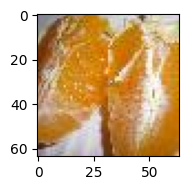

In [5]:
from imagenet_classify_trainer.config import TINY_IMAGENET_DATA_DIR
from torchvision import transforms
from PIL import Image

import torch.nn.functional as F
import matplotlib.pyplot as plt
import os, json, torch

with open(os.path.join(TINY_IMAGENET_DATA_DIR, 'val_class_dict_10.json')) as f:
    val_lables_dict = json.load(f)

custom_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), # already divides pixels by 255. internally
    lambda x: torch.unsqueeze(x, 0)
])
test_img_name = 'val_1067.JPEG'
test_img_path = os.path.join(TINY_IMAGENET_DATA_DIR, 'class_10_val', 'val_images', test_img_name)
test_image = Image.open(test_img_path)

print(f'image size={test_image.size}')
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(test_image)
plt.tight_layout()

X = custom_transform(test_image)
print(f'pred={model.predict(X)[0].item()}, actual={val_lables_dict[test_img_name]}')

In [6]:
from imagenet_classify_trainer.train import TrainerBuilder, Trainer
from imagenet_classify_trainer.config import TINY_IMAGENET_DATA_DIR
from imagenet_classify_trainer.data import TinyImageNetDataset

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

def accuracy(logits, y_true):
    y_pred = torch.argmax(logits, 1)
    num_correct = torch.sum(y_pred == y_true).item()
    value = num_correct / len(y_true)
    return value

optimizer = Adam(model.parameters(), lr=0.001)
lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=10, factor=0.05, min_lr=0.00001)
trainer = TrainerBuilder() \
    .model(model) \
    .loss_fn(F.cross_entropy) \
    .optim(optimizer) \
    .lr_schedule(lr_scheduler) \
    .metric_fn(accuracy) \
    .build()

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), # already divides pixels by 255. internally
])
train_img_dir = os.path.join(TINY_IMAGENET_DATA_DIR, 'class_10_train')
train_lbl_file = os.path.join(TINY_IMAGENET_DATA_DIR, 'class_dict_10.json')
ds = TinyImageNetDataset(train_lbl_file, train_img_dir, img_transform)
dl = DataLoader(ds, batch_size=64, shuffle=True)

val_img_dir = os.path.join(TINY_IMAGENET_DATA_DIR, 'class_10_val', 'val_images')
val_ann_file = os.path.join(TINY_IMAGENET_DATA_DIR, 'val_class_dict_10.json')
ds = TinyImageNetDataset(val_ann_file, val_img_dir, img_transform)
vdl = DataLoader(ds, batch_size=64, shuffle=True)

trainer.train(dl, vdl, 1)

100%|██████████| 1/1 [00:33<00:00, 33.03s/it]


{'train': {'loss': 0.3858517702886104, 'score': 0.875},
 'val': {'loss': 7.887238144874573, 'score': 0.10748922413793104}}